## Estudo de Caso Visual com Grad-CAM em Imagem de raio-x

 Aplicar Grad-CAM em uma rede convolucional treinada para classificar imagens de raio-x como pneumonia ou não pneumonia.

 É utilizado o modelo pré-treinado resnet18 (disponível no PyTorch), que pode ser ajustado para 2 classes e aplicar Grad-CAM com auxílio da biblioteca torchcam. Usaremos uma imagem de raio-x da base pública Chest X-ray Pneumonia (Kaggle).



In [ ]:
!pip install torch torchvision torchcam matplotlib pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 865.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms import InterpolationMode, Resize
import requests
from io import BytesIO
import numpy as np


Carregar a imagem de raio-x

In [ ]:
url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/images/1-s2.0-S0929664620300449-gr2_lrg-b.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')

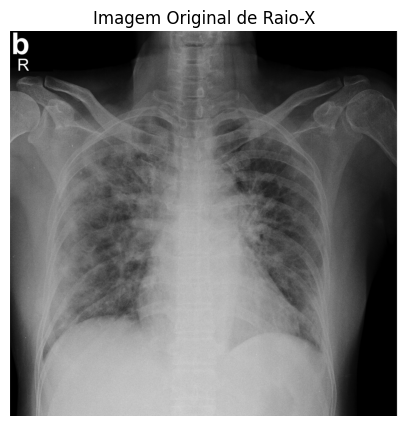

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Imagem Original de Raio-X")
plt.imshow(img)
plt.axis('off')
plt.show()

Transformação para tensor e normalização


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input_tensor = transform(img).unsqueeze(0)

Carregar modelo pré-treinado e ajustar saída para 2 classes

In [ ]:
model = resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)  # Simula um modelo treinado para pneumonia vs normal
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Grad-CAM: Gerar mapa de ativação

In [ ]:
cam_extractor = GradCAM(model, target_layer='layer4')

In [ ]:
#Inferência com Grad-CAM ativo
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()
classes = ['Normal', 'Pneumonia']
print(f"Predição do modelo: {classes[predicted_class]} (classe {predicted_class})")

Predição do modelo: Pneumonia (classe 1)


In [ ]:
# Gerar o mapa de calor
activation_map = cam_extractor(predicted_class, output)

In [ ]:
#Redimensiona o heatmap para 224x224 com interpolação bilinear
heatmap_tensor_resized = Resize((224, 224), interpolation=InterpolationMode.BILINEAR)(
    activation_map[0].unsqueeze(0)
).squeeze(0)

A interpolação bilinear é uma técnica de redimensionamento que calcula o valor de um novo pixel (em uma grade maior ou menor) como uma média ponderada dos 4 pixels vizinhos mais próximos na imagem original.

Com interpolação bilinear:
* A transição de cores e intensidades é suave.
* As bordas das regiões ativadas são mais naturais.
* A sobreposição com a imagem médica final fica mais fiel e interpretável.



In [ ]:
#Normalizar o heatmap
heatmap_tensor_resized = (heatmap_tensor_resized - heatmap_tensor_resized.min()) / \
                         (heatmap_tensor_resized.max() - heatmap_tensor_resized.min())

#Converter imagem original para PIL redimensionada
resized_img = transform(img)
resized_img_pil = transforms.ToPILImage()(resized_img)

In [ ]:
# 10. Criar sobreposição
overlay = overlay_mask(resized_img_pil, transforms.ToPILImage()(heatmap_tensor_resized), alpha=0.5)

In [ ]:
#Garantir que activation_map é tensor 2D
if isinstance(activation_map, list):
    activation_map = activation_map[0]
if activation_map.dim() == 3:
    activation_map = activation_map.squeeze(0)

#Redimensiona com interpolação bilinear para (224, 224)
heatmap_tensor_resized = Resize((224, 224), interpolation=InterpolationMode.BILINEAR)(
    activation_map.unsqueeze(0)
).squeeze(0)

#Normaliza o heatmap para [0, 255]
heatmap_normalized = (heatmap_tensor_resized - heatmap_tensor_resized.min()) / (
    heatmap_tensor_resized.max() - heatmap_tensor_resized.min()
)
heatmap_np = np.uint8(255 * heatmap_normalized.numpy())

#Aplica o colormap Jet (BGR) e converte para RGB
heatmap_color = cv2.applyColorMap(heatmap_np, cv2.COLORMAP_JET)
heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

#Converte imagem original e heatmap colorido para numpy
original_np = np.array(resized_img_pil.convert("RGB"))
heatmap_color_rgb = np.array(Image.fromarray(heatmap_color_rgb))

#Faz sobreposição com alpha
alpha = 0.5
overlay_np = cv2.addWeighted(original_np, 1 - alpha, heatmap_color_rgb, alpha, 0)

#Converte para PIL para exibição (opcional)
overlay_pil = Image.fromarray(overlay_np)
heatmap_pil = Image.fromarray(heatmap_color_rgb)

Gerar Imagens

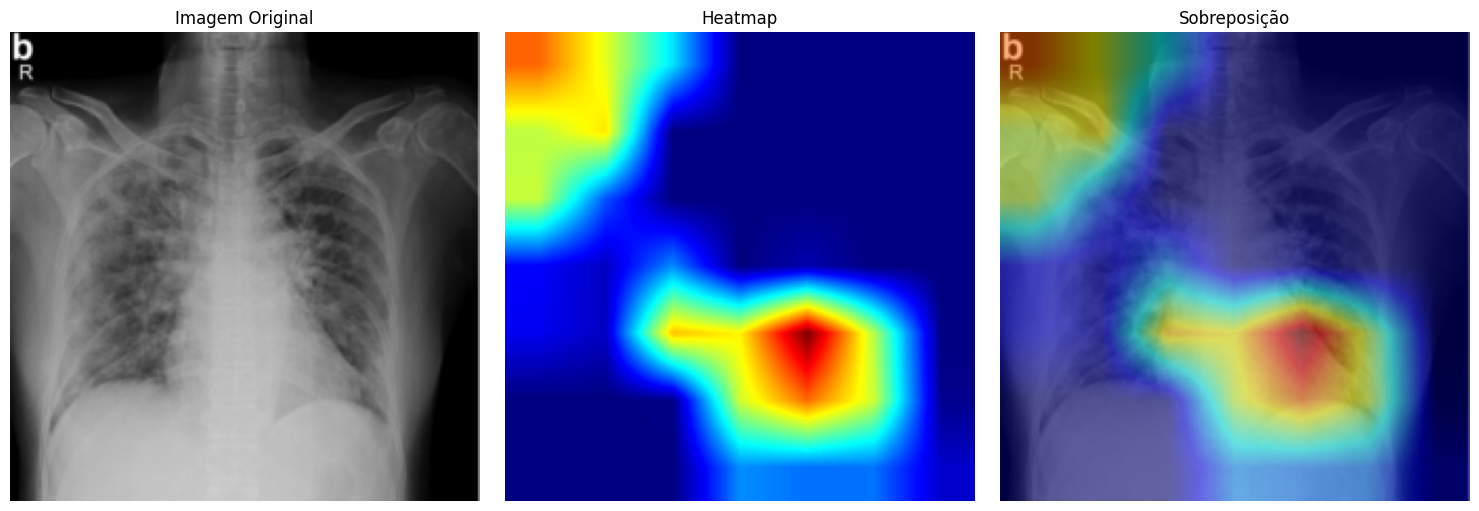

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(resized_img_pil)
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap_pil)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay_pil)
plt.title("Sobreposição")
plt.axis('off')

plt.tight_layout()
plt.show()